ctrl shift alt enter: debug

In [34]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def torch_fix_seed(seed=42):
    """ 乱数シードを固定
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

# 学習データセットの準備

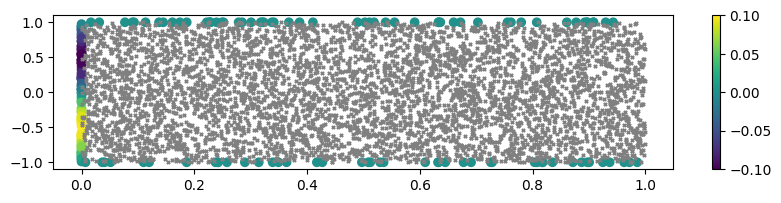

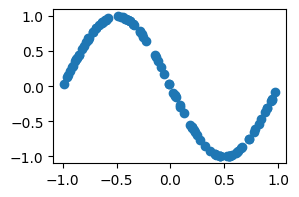

In [35]:
# 初期条件: x∈[-1,1], t=0のとき，u=-sin(x)
n_initial = 100
t_initial = np.zeros(n_initial) 
x_initial = (np.random.random(n_initial) - 0.5) * 2 
u_initial = -1 * np.sin(np.pi * x_initial)

# 境界条件: x=-1 or x=1, t∈[0,1]のとき，u=0
n_boundary = 100        
t_boundary = np.random.random(n_boundary)
x_boundary = np.random.choice([-1, 1], n_boundary)
u_boundary = np.zeros(n_boundary)

# 支配方程式の残差を評価する計算領域内の座標
n_region = 5000
t_region = np.random.random(n_region)
x_region = (np.random.random(n_region)- 0.5) * 2 

# 可視化
plt.figure(figsize=(10, 2))
plt.scatter(t_initial, x_initial, c=u_initial)
plt.scatter(t_boundary, x_boundary, c=u_boundary)
plt.colorbar()
plt.scatter(t_region, x_region, c="gray", s=5, marker="x")
plt.show()

plt.figure(figsize=(3, 2))
plt.scatter(x_initial, u_initial)
plt.show()

# ネットワークの構築

In [36]:
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hiddens=[32,64,128,128,64,32]):
        
        super(NN, self).__init__()
        
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(n_input, n_hiddens[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(n_hiddens[i], n_hiddens[i+1]) for i in range(len(n_hiddens)-1)]
        )
        self.output_layer = nn.Linear(n_hiddens[-1], n_output)
        
        
    def forward(self, x):
        
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        x = self.output_layer(x)
        
        return x

In [37]:
class BurgersPINN():
    def __init__(self, model):
        """ 
        """
        self.model = model
        self.nu = 0.1
        
        
    def net_u(self, x, t):
        """ 物理量を出力
        """
        u = self.model(torch.cat([x, t], dim=1))
        return u


    def net_f(self, x, t):
        """ 支配方程式との残差を出力
        """    
        # モデルが予測する物理量
        u = self.net_u(x, t)
        
        # 微分係数を逆伝搬で計算
        du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dxx = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        
        # 支配方程式に代入(f=0だと方程式と完全一致)
        f = du_dt + u * du_dx - self.nu * du_dxx 
        
        return f
    
    
    def fit(self, X_bc, Y_bc, X_region, max_epochs=300, learning_rate=0.01, pi_weight=5e-4):
        """ 学習データでモデルを訓練
        """
        # 入力データをスライス
        t = X_bc[:, [0]]
        x = X_bc[:, [1]]
        u = Y_bc 
        t_region = X_region[:, [0]] 
        x_region = X_region[:, [1]]
        
        # 入力をtorch.tensorに変換
        t = torch.tensor(t, requires_grad=True).float()
        x = torch.tensor(x, requires_grad=True).float()
        u = torch.tensor(u, requires_grad=True).float()
        x_region = torch.tensor(x_region, requires_grad=True).float()
        t_region = torch.tensor(t_region, requires_grad=True).float()
        
        # 最適化ロジック
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # モデルを学習モードに変更
        self.model.train()
        
        # 学習
        history = []
        for epoch in range(max_epochs+1):
            
            # 現在のモデルで予測
            u_pred = self.net_u(x, t)
            f_pred = self.net_f(x_region, t_region)
            
            # 損失を計算
            loss_u = torch.mean((u - u_pred)**2)
            loss_pi = torch.mean(f_pred**2)
            loss_total = loss_u + loss_pi * pi_weight
            
            # 誤差逆伝搬
            loss_total.backward()
            
            # 最適化ソルバーで重みを動かす
            optimizer.step()
            
            # 最適化ソルバーの勾配情報を初期化
            optimizer.zero_grad()
            
            if epoch % 100 == 0:
                print(f'epoch:{epoch}, loss:{loss_total.item()}, loss_u:{loss_u.item()}, loss_pi:{loss_pi.item()}')
            
                history.append([epoch, loss_total.item(), loss_u.item(), loss_pi.item()])
        
        return np.array(history)
                
    def predict(self, X_in):
        """ モデルの予測
        """
        t = X_in[:, [0]]
        x = X_in[:, [1]]
        
        # 入力をtorch.tensorに変換
        t = torch.tensor(t, requires_grad=True).float()
        x = torch.tensor(x, requires_grad=True).float()
        
        self.model.eval()  # 評価モードに変更

        u = self.net_u(x, t).detach().numpy()
        f = self.net_f(x, t).detach().numpy()
        
        return u, f

In [38]:
# 学習用のデータ
X_bc = np.block([[t_initial, t_boundary], [x_initial, x_boundary]]).T
Y_bc = np.block([[u_initial, u_boundary]]).T
X_region = np.block([[t_region], [x_region]]).T

print("shape:", X_bc.shape, Y_bc.shape, X_region.shape)

model = NN(2, 1)
pinn_model = BurgersPINN(model)

# モデルを学習
history = pinn_model.fit(X_bc, Y_bc, X_region, max_epochs=1000)

shape: (200, 2) (200, 1) (5000, 2)
epoch:0, loss:0.26071280241012573, loss_u:0.26071271300315857, loss_pi:0.0001576140202814713
epoch:100, loss:0.0010276150424033403, loss_u:0.00043831090442836285, loss_pi:1.1786080598831177
epoch:200, loss:0.0009814678924158216, loss_u:0.0004998243530280888, loss_pi:0.9632871150970459
epoch:300, loss:0.0006061568856239319, loss_u:0.0002917731471825391, loss_pi:0.6287674903869629
epoch:400, loss:0.0003322211850900203, loss_u:0.00022632142645306885, loss_pi:0.2117994874715805
epoch:500, loss:0.0007690330385230482, loss_u:0.0006257332861423492, loss_pi:0.28659945726394653
epoch:600, loss:0.0004646197776310146, loss_u:0.0002989245986100286, loss_pi:0.3313903212547302
epoch:700, loss:0.00022964565141592175, loss_u:0.00015250276192091405, loss_pi:0.15428577363491058
epoch:800, loss:0.0005820312653668225, loss_u:0.00044430862180888653, loss_pi:0.27544525265693665
epoch:900, loss:0.00028368085622787476, loss_u:0.00012921450252179056, loss_pi:0.308932662010192

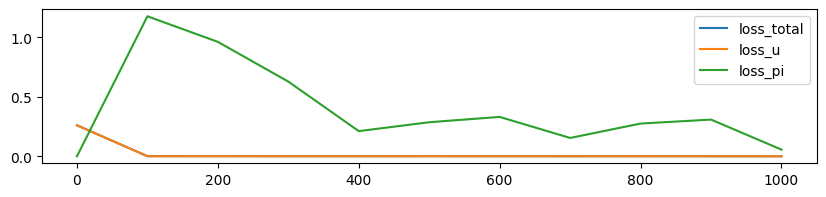

In [39]:
plt.figure(figsize=(10,2))
plt.plot(history[:, 0], history[:, 1], label='loss_total')
plt.plot(history[:, 0], history[:, 2], label='loss_u')
plt.plot(history[:, 0], history[:, 3], label='loss_pi')
plt.legend()

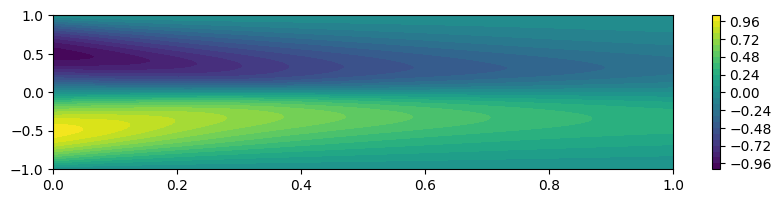

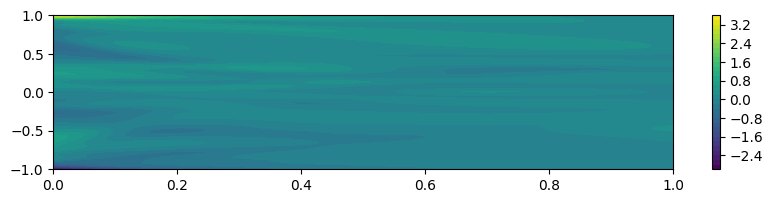

In [45]:
# 予測したいポイント
n = 100
t_pred = np.linspace(0, 1, n)
x_pred = np.linspace(-1, 1, n)
t_grid, x_grid = np.meshgrid(t_pred, x_pred)

X_in = np.block([[t_grid.flatten()], [x_grid.flatten()]]).T

# 予測
u_pred, f_pred = pinn_model.predict(X_in)
u_pred = u_pred.reshape(n, n)
f_pred = f_pred.reshape(n, n)

# 物理量を可視化
plt.figure(figsize=(10, 2))
plt.contourf(t_pred, x_pred, u_pred, 32)
plt.colorbar()
plt.show()

# 基礎方程式の残差を可視化
plt.figure(figsize=(10, 2))
plt.contourf(t_pred, x_pred, f_pred, 32)
plt.colorbar()
plt.show()

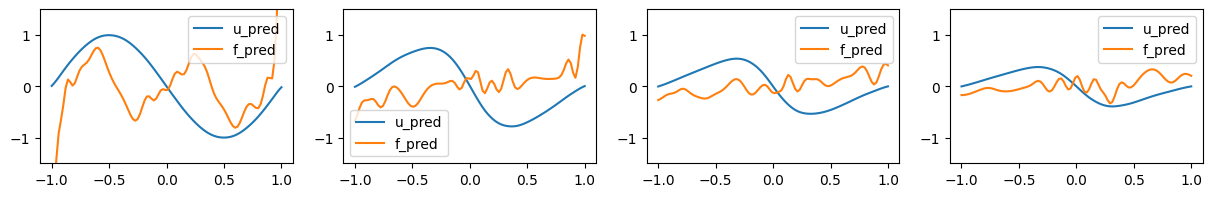

In [49]:
times = [0, 0.25, 0.5, 0.75]

fig = plt.figure(figsize=(15, 2))

for i, t in enumerate(times):
    t_pred = np.ones([100, 1]) * t
    X_in = np.column_stack([t_pred, x_pred])
    u_pred, f_pred = pinn_model.predict(X_in)
    
    fig.add_subplot(1, 4, i+1)    
    plt.plot(x_pred, u_pred, label='u_pred')
    plt.plot(x_pred, f_pred, label='f_pred')
    plt.ylim(-1.5, 1.5)
    plt.legend()
plt.show()
    